<a href="https://colab.research.google.com/github/goya5858/OSERO/blob/main/Actor_Critic_cartpole_with_TDLoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import torch.multiprocessing as mp
import time

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

# Agent

In [174]:
class Agent_Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1  = nn.Linear(4, 16)
        self.act1 = nn.ReLU()

        self.fc2  = nn.Linear(16, 16)
        self.act2 = nn.ReLU()

        self.pi_net = nn.Linear(16, 2)
        self.pi_act = nn.Softmax()

        self.V_net = nn.Linear(16,1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        pi = self.pi_net(x)
        pi = self.pi_act(pi)

        V = self.V_net(x)
        return pi, V

In [3]:
import torch
import numpy as np
from torch.distributions import Categorical

a = torch.tensor([0.3, 0.7] )
m = Categorical(a)

S = []
for i in range(1000):
    S.append( m.sample() )


m.log_prob(m.sample())

tensor(-1.2040)

In [18]:
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'state_next', 'log_prob', 'v_value') )

class Agent_Memory():
    def __init__(self):
        self.capacity = CAPACITY #メモリの大きさ
        self.memory = []
        self.index = 0

    def sample(self):
        transitions = self.memory
        BATCH = Transition(*zip(*transitions)) #State, Action, Reward, State_Nextの各要素ごとにまとめ直す

        State_BATCH      = torch.tensor( np.stack( BATCH.state ) ,dtype=torch.float)
        Action_BATCH     = torch.tensor( np.stack( BATCH.action ) ,dtype=torch.int64)
        Reward_BATCH     = torch.tensor( np.stack( BATCH.reward ) ,dtype=torch.float)
        Log_prob_BATCH   = torch.stack( BATCH.log_prob )
        V_value_BATCH    = torch.stack( BATCH.v_value )
        State_Next_BATCH = np.array( BATCH.state_next ) 
        non_final_mask   = [s is not None for s in State_Next_BATCH]
        State_Next_BATCH = torch.tensor( np.stack(State_Next_BATCH[non_final_mask] ) ,dtype=torch.float)
        return State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask, Log_prob_BATCH, V_value_BATCH

    def put_memory(self, state, action, reward, state_next, log_prob, v_value):
        '''transition = (state, action, reward, state_next)をメモリに保存する'''
        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す
        self.memory[self.index] = Transition(state, action, reward, state_next, log_prob, v_value)
        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

In [176]:
class Agent():
    def __init__(self):
        self.Network = Agent_Network()
        self.Memory  = Agent_Memory()
        self.optim   = optim.Adam(self.Network.parameters(), lr=0.01)

    def get_action(self, state, episode): 
        # ε-greedy法で徐々に最適行動のみを採用する
        #self.Network.eval()  # ネットワークを推論モードに切り替える
        pi_values, V_value = self.Network( torch.tensor( state, dtype=torch.float ) )
        m = Categorical(pi_values)

        epsilon = 0.5 * (1 / (episode + 1))
        if epsilon <= np.random.uniform(0, 1):
            action = m.sample()
        else:
            action = np.random.choice(2)   # 0,1の行動をランダムに返す
            action = torch.tensor( action )
        #log_prob = -1 * m.log_prob(action)
        pi_prob = m.probs[ action.to(torch.long) ]
        return action, pi_prob, V_value[0]

    def update_Network(self):
        # Memoryから学習用のデータを取り出す
        State_BATCH, Action_BATCH, Reward_BATCH, State_Next_BATCH, non_final_mask, Pi_prob_BATCH, V_value_BATCH = self.Memory.sample()
        
        next_V_values = torch.zeros( len(State_BATCH) )
        next_V_values[non_final_mask] = self.get_action(State_Next_BATCH, 500)[1].max(-1)[0].detach()
        Advantage = (Reward_BATCH + GAMMA * next_V_values).detach() - V_value_BATCH

        #R = 0
        #for i in reversed( range(len(Reward_BATCH)) ):
        #    r = Reward_BATCH[i]
        #    R = r + GAMMA * R
        #    Reward_BATCH[i] = R
        #Advantage = Reward_BATCH - V_value_BATCH
        
        V_loss  = Advantage.pow(2).mean() #２乗平均をとる
        Log_prob_BATCH = -1 * torch.log( Pi_prob_BATCH )
        pi_gain = ( Log_prob_BATCH * Advantage.detach() ).mean()
        entropy  = -1 * ( Pi_prob_BATCH * Log_prob_BATCH ).mean()

        loss = V_loss + pi_gain + entropy*0.1

        self.optim.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.Network.parameters(), 0.001)
        self.optim.step() 
        
        self.Memory.memory = []
        self.Memory.index = 0
    
    def memorize(self, state, action, reward, state_next, log_prob, v_value):
        self.Memory.put_memory(state, action, reward, state_next, log_prob, v_value)

In [91]:
agent = Agent()

for i in range(30):
    s = np.array([0,0,0,0])
    a, pi_prob, V_value = agent.get_action(s, 0)
    r = i
    if i != 29:
        s_next = np.array([1,1,1,1])
    else:
        s_next = None
    agent.memorize(s, a, r, s_next, pi_prob, V_value)

A = agent.update_Network()
A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


# Task

In [92]:
Task_model = gym.make('CartPole-v0')

# Training Environment

In [137]:
class Environment():
    def __init__(self):
        self.Task  = Task_model
        self.Agent = Agent()
    
    def run_one_episode(self, episode):
        # 倒れるか、200秒持ち堪え耐えるまでが１エピソード        
        t = 0
        state = self.Task.reset() # 各episodeの最初にTaskをリセット
        reword = 0

        while True:
            action, pi_prob, v_value  = self.Agent.get_action(state, episode)
            state_next, reword, done, info = self.Task.step(action.item()) #Action_tを場面に渡してState_t+1, Reword_tを受け取る
            
            if done: #倒れていたor終了した場合
                next_state = None
                if t < 195: #195ステップいないなら失敗
                    reword = -1
                else: #195ステップ以上たってたら成功
                    reword = 1
            else: #各ステップで立ってたら報酬追加
                reword = 0
            
            # 結果の記録とモデルの更新
            self.Agent.memorize(state, action, reword, state_next, pi_prob, v_value)
            

            state = state_next
            t += 1

            if done:
                break
        self.Agent.update_Network() #エピソードの終わりに更新
        return t
    
    def train(self):
        TIMES = []
        times = 0
        episode = 0
        while True:
            times = self.run_one_episode(episode)
            print('episode :', episode)
            print(times)
            print('='*10)
            episode += 1
            TIMES.append(times)

            if ( (len(TIMES) > 10) & (np.mean(TIMES[-10:]) >= 180) ) or (len(TIMES) > MAX_ITER):
                break
        return TIMES

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


ストリーミング出力は最後の 5000 行に切り捨てられました。
20
episode : 3335
10
episode : 3336
30
episode : 3337
12
episode : 3338
22
episode : 3339
13
episode : 3340
15
episode : 3341
19
episode : 3342
21
episode : 3343
16
episode : 3344
46
episode : 3345
15
episode : 3346
10
episode : 3347
47
episode : 3348
13
episode : 3349
27
episode : 3350
16
episode : 3351
13
episode : 3352
37
episode : 3353
15
episode : 3354
27
episode : 3355
42
episode : 3356
19
episode : 3357
60
episode : 3358
14
episode : 3359
15
episode : 3360
24
episode : 3361
20
episode : 3362
24
episode : 3363
11
episode : 3364
15
episode : 3365
14
episode : 3366
30
episode : 3367
19
episode : 3368
16
episode : 3369
17
episode : 3370
32
episode : 3371
13
episode : 3372
42
episode : 3373
13
episode : 3374
13
episode : 3375
20
episode : 3376
41
episode : 3377
19
episode : 3378
14
episode : 3379
34
episode : 3380
19
episode : 3381
20
episode : 3382
10
episode : 3383
13
episode : 3384
24
episode : 3385
20
episode : 3386
30
episode : 3387
22
episode : 3

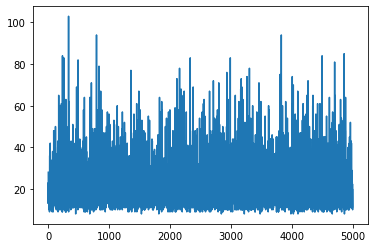

In [178]:
GAMMA = 0.99
CAPACITY = 10000
#BATCH_SIZE = 32
MAX_ITER = 5000

AAA = Environment()
TTT = AAA.train()

X = range(len(TTT))
plt.plot(X, TTT)